In [1]:
import os
os.chdir('../..')
import numpy as np
import torch
import pickle
from tqdm import tqdm
from rdkit.Chem import MolFromInchi
from rdkit.Chem.rdmolops import Kekulize
from sklearn.model_selection import KFold


RDKit WARNING: [15:18:14] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
from molgrad.utils import DATA_PATH, EXAMPLE_PATH, MODELS_PATH
from molgrad.vis import molecule_importance
from molgrad.net import MPNNPredictor
from molgrad.train import DEVICE, SEED, N_FOLDS

Using backend: pytorch


In [3]:
FOLD_NO = 3

with open(os.path.join(DATA_PATH, "caco2", "data_caco2.pt"), "rb") as handle:
            inchis, values = pickle.load(handle)

inchis = np.array(inchis)
values = np.array(values)[:, np.newaxis]

kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
_, idx_test =  list(kf.split(inchis))[FOLD_NO]

inchis, values = inchis[idx_test].tolist(), values[idx_test, :].squeeze().tolist()


In [4]:
sim = np.load(os.path.join(DATA_PATH, "caco2", f"sim_caco2_fold{FOLD_NO}.npy"))
preds = np.load(os.path.join(DATA_PATH, "caco2", f"preds_fold{FOLD_NO}.npy"))
diff_true = np.load(os.path.join(DATA_PATH, "caco2", f"diff_exp_fold{FOLD_NO}.npy"))
diff_hat = np.load(os.path.join(DATA_PATH, "caco2", f"diff_hat_fold{FOLD_NO}.npy"))

In [5]:
sim.shape

(24, 24)

In [6]:
diff_true.shape

(24, 24)

In [7]:
diff_hat.shape

(24, 24)

In [8]:
preds.shape

(24,)

In [9]:
len(inchis)

24

In [10]:
ligand_i = []
ligand_j = []
values_i = []
values_j = []
preds_i = []
preds_j = []

long_sim = []
long_true = []
long_hat = []

for idx_i, (inchi_i, exp_i, pred_i) in enumerate(zip(inchis, values, preds)):
    for idx_j, (inchi_j, exp_j, pred_j) in enumerate(zip(inchis, values, preds)):
        if idx_i < idx_j:
            ligand_i.append(inchi_i)
            ligand_j.append(inchi_j)
            values_i.append(exp_i)
            values_j.append(exp_j)
            preds_i.append(pred_i)
            preds_j.append(pred_j)
            long_sim.append(sim[idx_i, idx_j])
            long_true.append(diff_true[idx_i, idx_j])
            long_hat.append(diff_hat[idx_i, idx_j])

In [11]:
import pandas as pd
pd.set_option('display.max_rows', 1000)

df_pairs = pd.DataFrame({'inchi_i': ligand_i,
                         'inchi_j': ligand_j,
                         'values_i': values_i,
                         'values_j': values_j,
                         'preds_i': preds_i,
                         'preds_j': preds_j,
                         'similarity': long_sim,
                         'diff_exp': long_true,
                         'diff_pred': long_hat})


In [12]:
def sali_index(sim, diff):
    return np.abs(diff) / (1 - sim)

In [13]:
df_pairs = df_pairs.loc[df_pairs['similarity'] < 1.0]
df_pairs['sali_exp'] = sali_index(df_pairs['similarity'], df_pairs['diff_exp'])
df_pairs['sali_pred'] = sali_index(df_pairs['similarity'], df_pairs['diff_pred'])
df_pairs.sort_values('sali_pred', ascending=False, inplace=True)
df_pairs.reset_index(inplace=True)

In [14]:
df_pairs.head(n=200)

,index,inchi_i,inchi_j,values_i,values_j,preds_i,preds_j,similarity,diff_exp,diff_pred,sali_exp,sali_pred
0,151,InChI=1S/C27H29NO11/c1-10-22(31)13(28)6-17(38-...,InChI=1S/C17H20N2S/c1-13(18(2)3)12-19-14-8-4-6...,6.222233,3.775545,6.501972,3.650889,0.086667,2.446688,2.851083,2.678856,3.121624
1,18,InChI=1S/C8H9NO2/c1-6(10)9-7-2-4-8(11)5-3-7/h2...,InChI=1S/C17H20N2S/c1-13(18(2)3)12-19-14-8-4-6...,4.392703,3.775545,6.119437,3.650889,0.144737,0.617159,2.468548,0.721601,2.886302
2,261,InChI=1S/C47H51NO14/c1-25-31(60-43(56)36(52)35...,InChI=1S/C17H20N2S/c1-13(18(2)3)12-19-14-8-4-6...,6.063613,3.775545,6.073775,3.650889,0.140000,2.288069,2.422887,2.660545,2.817310
3,180,InChI=1S/C12H22O11/c13-1-4-6(16)8(18)9(19)11(2...,InChI=1S/C17H20N2S/c1-13(18(2)3)12-19-14-8-4-6...,6.022276,3.775545,6.173848,3.650889,0.008547,2.246732,2.522959,2.266100,2.544709
4,267,InChI=1S/C17H20N2S/c1-13(18(2)3)12-19-14-8-4-6...,InChI=1S/C32H32O13S/c1-37-19-6-13(7-20(38-2)25...,3.775545,5.936055,3.650889,5.943843,0.092486,-2.160510,-2.292954,2.380689,2.526631
5,266,InChI=1S/C17H20N2S/c1-13(18(2)3)12-19-14-8-4-6...,"InChI=1S/C14H21N3O2S/c1-15-20(18,19)10-11-4-5-...",3.775545,5.635219,3.650889,5.685944,0.178947,-1.859675,-2.035055,2.264988,2.478593
6,235,"InChI=1S/C7H8ClN3O4S2/c8-4-1-5-7(2-6(4)16(9,12...",InChI=1S/C17H20N2S/c1-13(18(2)3)12-19-14-8-4-6...,5.853837,3.775545,5.931126,3.650889,0.062500,2.078293,2.280237,2.216845,2.432253
7,49,InChI=1S/C10H10FNO2/c11-6-2-1-3-7-10(6)14-9-5-...,InChI=1S/C27H29NO11/c1-10-22(31)13(28)6-17(38-...,3.698970,6.222233,4.414645,6.501972,0.113636,-2.523263,-2.087327,2.846758,2.354933
8,88,"InChI=1S/C15H12N2O2/c18-13-15(17-14(19)16-13,1...",InChI=1S/C27H29NO11/c1-10-22(31)13(28)6-17(38-...,4.351935,6.222233,4.410028,6.501972,0.102740,-1.870298,-2.091944,2.084454,2.331479
9,40,InChI=1S/C9H8O4/c1-6(10)13-8-5-3-2-4-7(8)9(11)...,InChI=1S/C17H20N2S/c1-13(18(2)3)12-19-14-8-4-6...,5.145110,3.775545,5.539390,3.650889,0.164557,1.369565,1.888501,1.639328,2.260478


In [15]:
model_pt = os.path.join(MODELS_PATH, f'caco2_noHs_fold{FOLD_NO}.pt')

model = MPNNPredictor(node_in_feats=49,
                      edge_in_feats=10,
                      global_feats=4,
                      n_tasks=1).to(DEVICE) 
model.load_state_dict(torch.load(model_pt,
                                 map_location=DEVICE))

<All keys matched successfully>

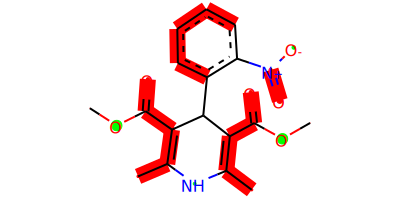

In [16]:
inchi_i, inchi_j = df_pairs.loc[119, 'inchi_i'],  df_pairs.loc[119, 'inchi_j']
mol_i, mol_j = MolFromInchi(inchi_i), MolFromInchi(inchi_j)
#Kekulize(mol_i)
#Kekulize(mol_j)
svg, img, _, _, global_importance = molecule_importance(mol_i,
                                                      model,
                                                      task=0,
                                                      version=2,
                                                      vis_factor=10,
                                                      eps=1e-4,
                                                      addHs=False)
img

In [17]:
with open(os.path.join(EXAMPLE_PATH, "caco2_cliff_oof_neg.svg"), "w+") as handle:
    handle.write(svg)

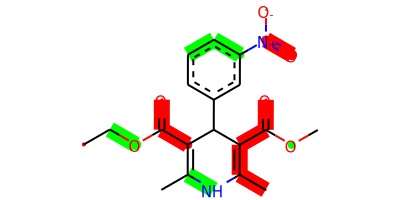

In [18]:
svg, img, _, _, global_importance = molecule_importance(mol_j,
                                                      model,
                                                      task=0,
                                                      version=2,
                                                      vis_factor=10,
                                                      eps=1e-4,
                                                      addHs=False)
img

In [19]:
with open(os.path.join(EXAMPLE_PATH, "caco2_cliff_oof_pos.svg"), "w+") as handle:
    handle.write(svg)